In [1]:
!pip install datasets transformers rouge_score tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6396c46c3bfe94b48f5dd71536ef27269484651ea7580fddd37caa476cc6be1d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
from transformers import DataCollatorForLanguageModeling

# Load the model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

# Freeze all model parameters except the language modeling (LM) head
for param in foundation_model.parameters():
    param.requires_grad = False
for param in foundation_model.lm_head.parameters():
    param.requires_grad = True



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
import transformers
import time
from rouge_score import rouge_scorer  # Using rouge_score directly


In [4]:
foundation_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
# Check the number of parameters to verify
total_params = sum(p.numel() for p in foundation_model.parameters())
trainable_params = sum(p.numel() for p in foundation_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 124439808
Trainable parameters: 38597376


In [12]:

# Load and preprocess the dataset
data = load_dataset("cnn_dailymail", "3.0.0")
tokenizer.pad_token = tokenizer.eos_token

# Using only a 10% of the data
train_size, test_size, validation_size = [int(0.1 * len(data[split])) for split in ['train', 'test', 'validation']]
train_sample = data['train'].select(range(train_size))
test_sample = data['test'].select(range(test_size))
validation_sample = data['validation'].select(range(validation_size))

# Preprocessing function
def preprocess_function(examples):
    model_inputs = tokenizer(examples["article"], max_length=512, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_data_train = train_sample.map(preprocess_function, batched=True)
tokenized_data_test = test_sample.map(preprocess_function, batched=True)
tokenized_data_validation = validation_sample.map(preprocess_function, batched=True)


Map:   0%|          | 0/28711 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1149 [00:00<?, ? examples/s]

Map:   0%|          | 0/1336 [00:00<?, ? examples/s]

In [13]:
# Define output directory for the fine-tuned model
output_directory = "./gpt2_finetuned_last_layers"

# Initialize ROUGE scorer
rouge_scorer_instance = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Compute added parameters
added_params = sum(p.numel() for p in foundation_model.lm_head.parameters() if p.requires_grad)

# Track computation time
start_time = time.time()

In [14]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=output_directory,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=50,
    save_steps=100,
    learning_rate=3e-4,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    report_to="none",
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Accumulate scores for each metric
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
    for pred, label in zip(decoded_preds, decoded_labels):
        scores = rouge_scorer_instance.score(pred, label)
        rouge1_scores.append(scores["rouge1"].fmeasure)
        rouge2_scores.append(scores["rouge2"].fmeasure)
        rougeL_scores.append(scores["rougeL"].fmeasure)

    # Calculate mean scores for each ROUGE metric
    result = {
        "rouge1": sum(rouge1_scores) / len(rouge1_scores) * 100,
        "rouge2": sum(rouge2_scores) / len(rouge2_scores) * 100,
        "rougeL": sum(rougeL_scores) / len(rougeL_scores) * 100
    }
    return result

In [20]:
trainer = Trainer(
    model=foundation_model,
    args=training_args,
    train_dataset=tokenized_data_train,
    eval_dataset=tokenized_data_validation,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [21]:
# Start training
trainer.train()


Step,Training Loss,Validation Loss
100,3.350700,3.431694
200,3.402100,3.336799
300,3.361300,3.283325
400,3.338800,3.252369
500,3.336400,3.230885
600,3.250900,3.216898
700,3.258600,3.208629
800,3.247400,3.199492
900,3.208800,3.197267
1000,3.236700,3.190312


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=2400, training_loss=3.235771662394206, metrics={'train_runtime': 1538.1113, 'train_samples_per_second': 55.999, 'train_steps_per_second': 14.0, 'total_flos': 2508403507200000.0, 'train_loss': 3.235771662394206, 'epoch': 0.33435497353023125})

In [32]:
# Track training end time
end_time = time.time()
total_time = end_time - start_time



In [33]:
print("Training time (seconds):", total_time)
print("Added parameters:", added_params)

Training time (seconds): 1699.6672704219818
Added parameters: 38597376


In [24]:
# Evaluate the model
test_results = trainer.evaluate(tokenized_data_test)
print("Test results:", test_results)

Test results: {'eval_loss': 3.1388018131256104, 'eval_runtime': 27.2823, 'eval_samples_per_second': 42.115, 'eval_steps_per_second': 5.278, 'epoch': 0.33435497353023125}


In [34]:
# prompt: correct syntax PYTORCH_CUDA_ALLOC_CONF=expandable_segments:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments"

In [35]:
testing_input_text=tokenized_data_test[0]["article"]
testing_output_text=tokenized_data_test[0]["highlights"]

print(testing_input_text)
print(testing_output_text)

(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's ceremony, sa

In [36]:
testing_input_text=tokenized_data_test[0]["article"]
testing_output_text=tokenized_data_test[0]["highlights"]

model=foundation_model
model.eval()

# Adjust the generate_summary function to handle device compatibility and output length
def generate_summary(text, max_new_tokens=128):
    model.config.pad_token_id = tokenizer.eos_token_id
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    tokenizer.pad_token = tokenizer.eos_token
    with torch.no_grad():
        output = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            pad_token_id=tokenizer.eos_token_id,
            max_new_tokens=max_new_tokens,  # Controls only the generated text length
            num_beams=5,
            early_stopping=True
        )

    return tokenizer.decode(output[0][:max_new_tokens], skip_special_tokens=True)

# Generate summary for the test input
generated_summary = generate_summary(testing_input_text)
print("Generated Summary:", generated_summary)

# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
scores = scorer.score(generated_summary, testing_output_text)

# Print ROUGE scores as percentages
print("ROUGE-1 Score:", scores["rouge1"].fmeasure )
print("ROUGE-2 Score:", scores["rouge2"].fmeasure )
print("ROUGE-L Score:", scores["rougeL"].fmeasure )

Generated Summary: (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of
ROUGE-1 Score: 0.3076923076923077
ROUGE-2 Score: 0.18439716312056736
ROUGE-L Score: 0.29370629370629375


In [37]:
!pip install tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize lists to store ROUGE scores for all test samples
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

# Loop through the test dataset with progress tracking
for test_example in tqdm(tokenized_data_test, desc="Processing test examples", unit="example"):
    testing_input_text = tokenizer.decode(test_example["input_ids"], skip_special_tokens=True)
    testing_output_text = tokenizer.decode(test_example["labels"], skip_special_tokens=True)

    # Generate summary for each test input
    generated_summary = generate_summary(testing_input_text)

    # Calculate ROUGE scores for the generated summary against the reference summary
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = scorer.score(generated_summary, testing_output_text)

    # Append each score to the respective list
    rouge1_scores.append(scores["rouge1"].fmeasure)
    rouge2_scores.append(scores["rouge2"].fmeasure)
    rougeL_scores.append(scores["rougeL"].fmeasure)


Processing test examples:   1%|          | 12/1149 [00:19<30:45,  1.62s/example]


KeyboardInterrupt: 

In [44]:

# Calculate the average ROUGE scores over the entire test dataset
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# Print the average ROUGE scores
print("Average ROUGE-1 Score:", average_rouge1)
print("Average ROUGE-2 Score:", average_rouge2)
print("Average ROUGE-L Score:", average_rougeL)

Average ROUGE-1 Score: 0.291331312387222
Average ROUGE-2 Score: 0.1292747932091129
Average ROUGE-L Score: 0.20238509188873338


In [45]:
# Number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

# Estimate GPU compute (in FLOPs)
flops = 2 * num_params * (training_args.per_device_train_batch_size * training_args.num_train_epochs)
print(f"Estimated FLOPs: {flops}")

# GPU memory usage
gpu_memory = torch.cuda.memory_allocated() / (1024**2)  # Convert to MB
print(f"GPU memory allocated: {gpu_memory:.2f} MB")


Number of trainable parameters: 38597376
Estimated FLOPs: 463168512
GPU memory allocated: 1857.42 MB


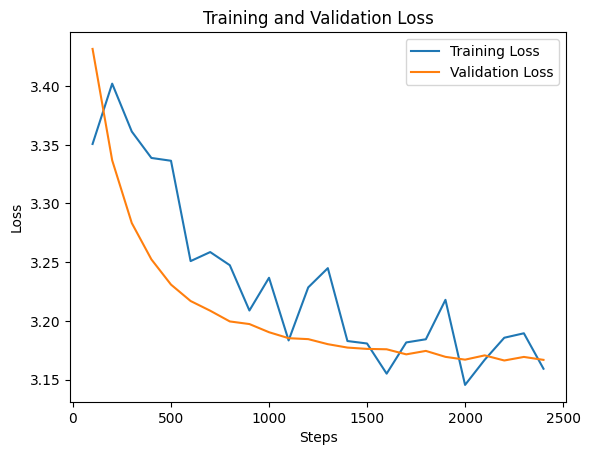

In [1]:
import matplotlib.pyplot as plt

steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400]

training_loss = [3.350700, 3.402100, 3.361300, 3.338800, 3.336400, 3.250900, 3.258600, 3.247400, 3.208800, 3.236700, 3.183300, 3.228500, 3.244900, 3.182800, 3.180700, 3.155000, 3.181600, 3.184300, 3.217900, 3.145400, 3.166800, 3.185600, 3.189400, 3.159200]

validation_loss = [3.431694, 3.336799, 3.283325, 3.252369, 3.230885, 3.216898, 3.208629, 3.199492, 3.197267, 3.190312, 3.185227, 3.184411, 3.180120, 3.177222, 3.176097, 3.175769, 3.171443, 3.174385, 3.169318, 3.166926, 3.170565, 3.166215, 3.169252, 3.166747]

# Plot the training and validation loss
plt.plot(steps, training_loss, label="Training Loss")
plt.plot(steps, validation_loss, label="Validation Loss")

# Set the plot title and labels
plt.title("Training and Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

# Add a legend
plt.legend()

# Display the plot
plt.show()